# Preparación de los datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
import pandas as pd
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
def load_images(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image_name = os.path.join(dirname, filename)
            image = cv.imread(image_name, cv.IMREAD_GRAYSCALE)
            images.append(image)
    return images

In [3]:
path_1 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/Folding marks/'
path_2 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/Grain off/'
path_3 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/Growth marks/'
path_4 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/loose grains/'
path_5 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/non defective/'
path_6 = '/home/vega/Escritorio/vision_artificial/tarea2/Leather_Deffects/Leather Defect Classification/pinhole/'

In [4]:
images_1 = load_images(path_1)
images_2 = load_images(path_2)
images_3 = load_images(path_3)
images_4 = load_images(path_4)
images_5 = load_images(path_5)
images_6 = load_images(path_6)

In [6]:
sample_1 = random.sample(images_1, 120 )
sample_2 = random.sample(images_2, 120 )
sample_3 = random.sample(images_3, 120 )
sample_4 = random.sample(images_4, 120 )
sample_6 = random.sample(images_6, 120 )
images_defective = sample_1 + sample_2 + sample_3 + sample_4 + sample_6
images_non_defective = images_5

# Extacción de características

In [7]:
def co_ocurrence_matrix_all_directions(img, distance, normalizar = True):
    step = [[distance, 0], [distance, distance], [0, distance], [-distance, distance]]
    glcm = []
    m, n = img.shape
    for thetha in range(4):
        M = np.zeros((256, 256))
        for i in range(m):
            for j in range(n):
                try:
                    x = i + step[i][1]
                    y = j + step[i][0]
                    if x >= 0 and y >= 0 :
                        p1 = int(img[i,j])
                        p2 = int(img[x,y])
                        M[p1][p2] += 1
                except IndexError:
                    j = n
        if normalizar:
            glcm.append(M/M.sum())
        else:
            glcm.append(M)
    return glcm


def get_all_descriptors_glcm(G, main_descriptors = True, normalizar = True):
    m, n = G[0].shape
    features = []
    for matrix in range(4):
        asm = 0
        ent = 0
        con = 0
        dis = 0
        hom = 0
        mu = 0
        for i in range(m):
            for j in range(n):
                asm += G[matrix][i,j]**2
                ent -= G[matrix][i,j]*math.log(G[matrix][i,j] + 1)
                con += G[matrix][i,j]*(i-j)**2
                dis += G[matrix][i,j]*abs(i-j)
                hom += (1/(1+ (i-j)**2))*G[matrix][i,j]
                mu += i*G[matrix][i,j]
        ene = (asm)**0.5
        cor = 0
        var = 0
        csha = 0
        cpro = 0
        for i in range(m):
            for j in range(n):
                cor += (i-mu)*(j-mu)*G[matrix][i,j]
                var += G[matrix][i,j]*(i-mu)**2
                csha += G[matrix][i,j]*(i+j-2*mu)**3
                cpro += G[matrix][i,j]*(i+j-2*mu)**4
        if main_descriptors:
            descriptors = [con, dis, hom, ene, cor, asm]
            if normalizar:
                suma = sum(descriptors)
                descriptors_norm = [x/suma for x in descriptors]
                features.append(descriptors_norm)
            else :
                features(descriptors)
        else:
            features([asm, ene, ent, con, dis, hom, mu, cor, var, csha, cpro])
    
    concat_features = [item for sublist in features for item in sublist]
    return concat_features/sum(concat_features)

def get_data_glcm(dataset_images, distance, normalizar = True):
    images = len(dataset_images)
    dataset_features = []
    for image in range(images):
        GLCM = co_ocurrence_matrix_all_directions(dataset_images[image], distance)
        feature = get_all_descriptors_glcm(GLCM)
        dataset_features.append(feature)
    return dataset_features
    

# Clasificación binaria

## División de los datos

In [8]:
total_images = images_defective + images_non_defective
total_labels = np.concatenate((np.ones(600), np.zeros(600)))

In [9]:
images_train, images_test, y_train, y_test = train_test_split(total_images, total_labels, shuffle = True, random_state=0, test_size=0.2)
X_train = get_data_glcm(images_train, 1)
X_test = get_data_glcm(images_test, 1)

## Modelos

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [58]:
models = {}
# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [85]:
def run_models(models, X_train, y_train, X_test, y_test, target_names):
    reports = {}
    for key in models:
        models[key].fit(X_train, y_train)
        predictions = models[key].predict(X_test)
        reports[key] = classification_report(y_test, predictions, target_names=target_names)
        print(key + '\n \n')
        print(reports[key])
        cm = confusion_matrix(y_test, predictions, labels=models[key].classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[key].classes_)
        disp.plot()
        plt.title(key)
        plt.show()
    return 

## Evaluación

Logistic Regression
 

                  precision    recall  f1-score   support

Piel sin defecto       0.71      0.74      0.72       130
Piel con defecto       0.67      0.64      0.65       110

        accuracy                           0.69       240
       macro avg       0.69      0.69      0.69       240
    weighted avg       0.69      0.69      0.69       240



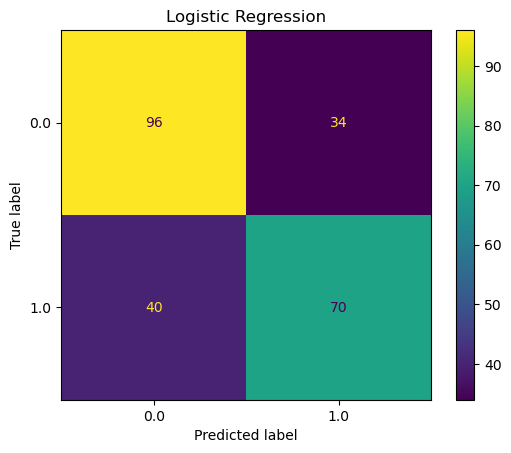

Support Vector Machines
 

                  precision    recall  f1-score   support

Piel sin defecto       0.73      0.83      0.78       130
Piel con defecto       0.76      0.64      0.69       110

        accuracy                           0.74       240
       macro avg       0.75      0.73      0.74       240
    weighted avg       0.74      0.74      0.74       240



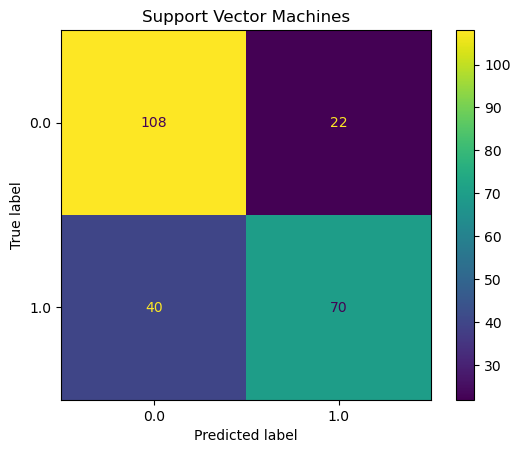

Decision Trees
 

                  precision    recall  f1-score   support

Piel sin defecto       0.81      0.82      0.82       130
Piel con defecto       0.79      0.77      0.78       110

        accuracy                           0.80       240
       macro avg       0.80      0.80      0.80       240
    weighted avg       0.80      0.80      0.80       240



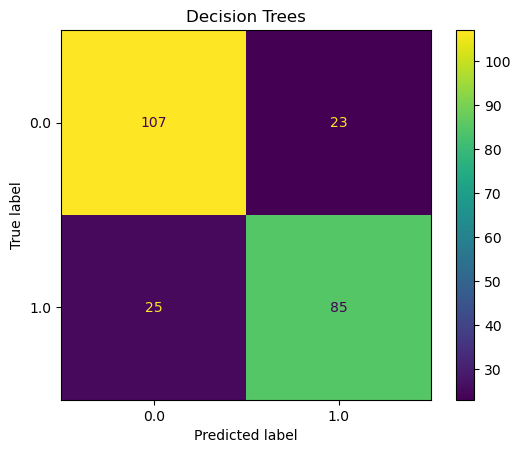

Random Forest
 

                  precision    recall  f1-score   support

Piel sin defecto       0.85      0.86      0.85       130
Piel con defecto       0.83      0.82      0.83       110

        accuracy                           0.84       240
       macro avg       0.84      0.84      0.84       240
    weighted avg       0.84      0.84      0.84       240



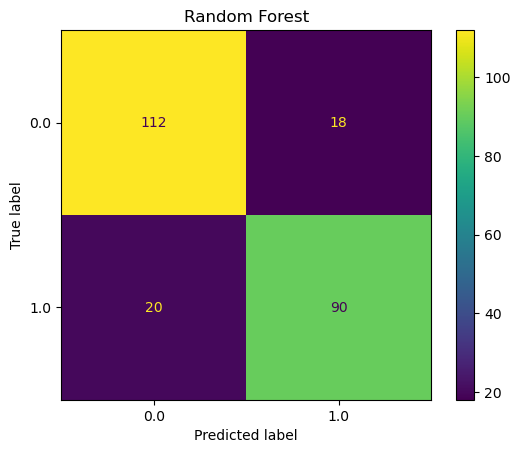

Naive Bayes
 

                  precision    recall  f1-score   support

Piel sin defecto       0.72      0.87      0.78       130
Piel con defecto       0.79      0.59      0.68       110

        accuracy                           0.74       240
       macro avg       0.75      0.73      0.73       240
    weighted avg       0.75      0.74      0.74       240



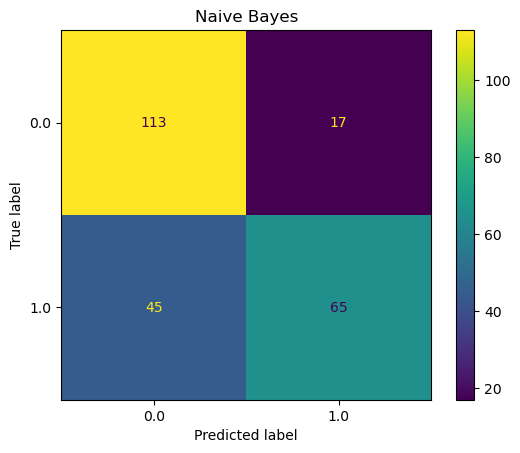

K-Nearest Neighbor
 

                  precision    recall  f1-score   support

Piel sin defecto       0.79      0.82      0.80       130
Piel con defecto       0.77      0.75      0.76       110

        accuracy                           0.78       240
       macro avg       0.78      0.78      0.78       240
    weighted avg       0.78      0.78      0.78       240



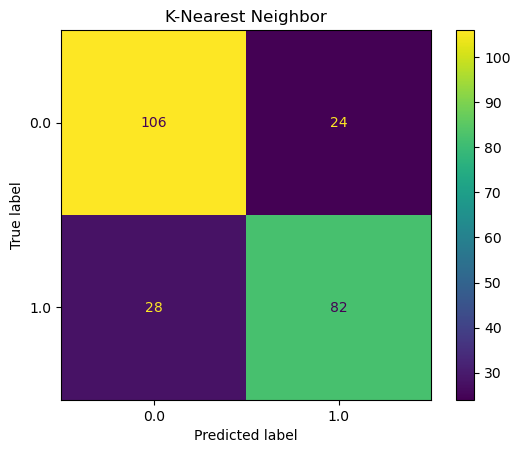

In [86]:
run_models(models, X_train, y_train, X_test, y_test, ['Piel sin defecto', 'Piel con defecto'])

# Clasificación  multiclase 

In [94]:
images= images_1 + images_2 + images_3 + images_4 + images_6
labels = np.concatenate((np.ones(600), 2*np.ones(600), 3*np.ones(600), 4*np.ones(600), 5*np.ones(600)))

In [95]:
images_train, images_test, y_train, y_test = train_test_split(images, labels, shuffle = True, random_state=123, test_size=0.2)
X_train = get_data_glcm(images_train, 1)
X_test = get_data_glcm(images_test, 1)

In [96]:
models = {}
# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [97]:
target_names = ['Folding marks', 'Grain off', 'Growth marks', 'Loose grains', 'Pinhole']

Logistic Regression
 

               precision    recall  f1-score   support

Folding marks       0.45      0.78      0.57       114
    Grain off       0.34      0.34      0.34       131
 Growth marks       0.57      0.96      0.72       112
 Loose grains       0.50      0.06      0.11       131
      Pinhole       0.05      0.03      0.03       112

     accuracy                           0.42       600
    macro avg       0.38      0.44      0.35       600
 weighted avg       0.38      0.42      0.35       600



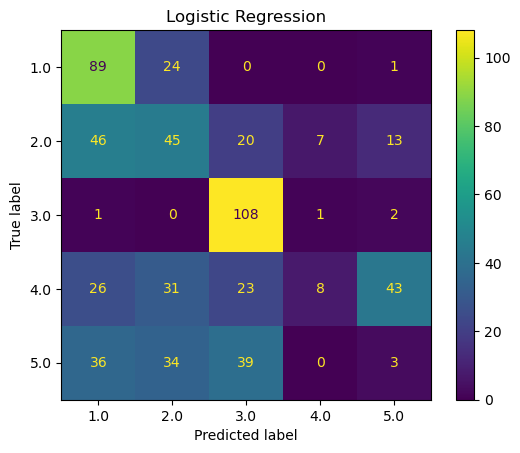

Support Vector Machines
 

               precision    recall  f1-score   support

Folding marks       0.43      0.84      0.57       114
    Grain off       0.33      0.33      0.33       131
 Growth marks       0.52      0.99      0.68       112
 Loose grains       0.25      0.03      0.05       131
      Pinhole       0.00      0.00      0.00       112

     accuracy                           0.42       600
    macro avg       0.30      0.44      0.33       600
 weighted avg       0.30      0.42      0.32       600



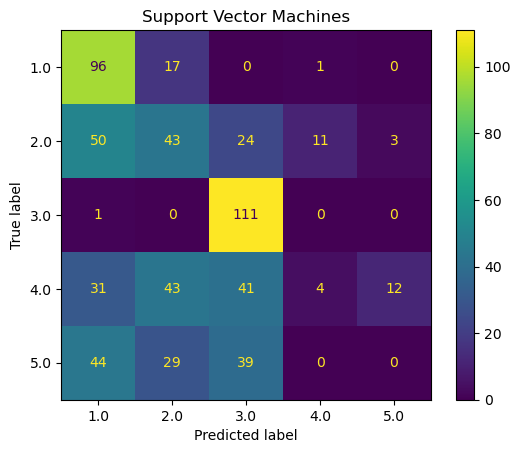

Decision Trees
 

               precision    recall  f1-score   support

Folding marks       0.53      0.51      0.52       114
    Grain off       0.38      0.37      0.38       131
 Growth marks       0.72      0.88      0.79       112
 Loose grains       0.58      0.58      0.58       131
      Pinhole       0.48      0.40      0.44       112

     accuracy                           0.54       600
    macro avg       0.54      0.55      0.54       600
 weighted avg       0.53      0.54      0.54       600



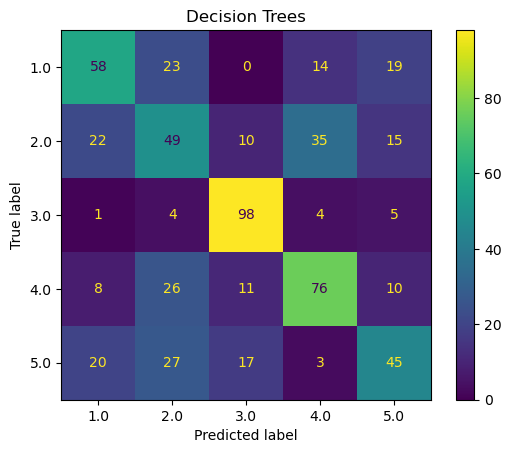

Random Forest
 

               precision    recall  f1-score   support

Folding marks       0.53      0.59      0.56       114
    Grain off       0.36      0.30      0.33       131
 Growth marks       0.71      0.90      0.79       112
 Loose grains       0.55      0.58      0.56       131
      Pinhole       0.54      0.39      0.45       112

     accuracy                           0.55       600
    macro avg       0.53      0.55      0.54       600
 weighted avg       0.53      0.55      0.53       600



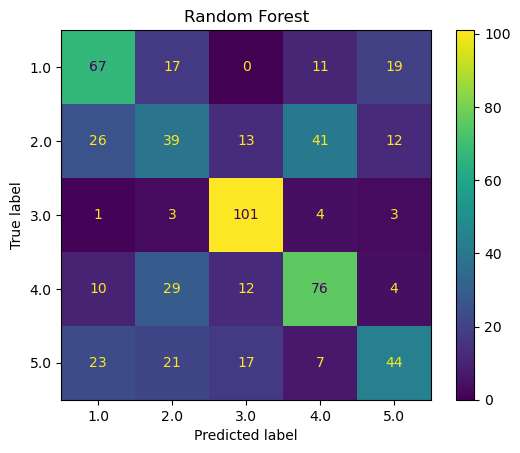

Naive Bayes
 

               precision    recall  f1-score   support

Folding marks       0.63      0.27      0.38       114
    Grain off       0.33      0.42      0.37       131
 Growth marks       0.57      0.99      0.72       112
 Loose grains       0.47      0.66      0.55       131
      Pinhole       0.50      0.02      0.03       112

     accuracy                           0.48       600
    macro avg       0.50      0.47      0.41       600
 weighted avg       0.49      0.48      0.41       600



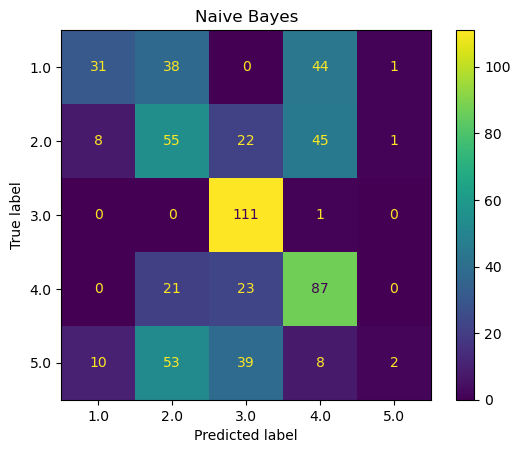

K-Nearest Neighbor
 

               precision    recall  f1-score   support

Folding marks       0.50      0.65      0.57       114
    Grain off       0.41      0.33      0.37       131
 Growth marks       0.69      0.88      0.78       112
 Loose grains       0.61      0.59      0.60       131
      Pinhole       0.46      0.33      0.39       112

     accuracy                           0.55       600
    macro avg       0.54      0.56      0.54       600
 weighted avg       0.53      0.55      0.54       600



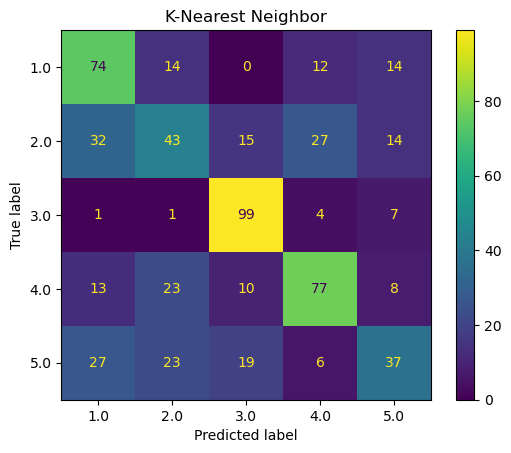

In [98]:
run_models(models, X_train, y_train, X_test, y_test, target_names)